# Fire Spread Simulation
## Introduction
This notebook is based on the `fire` model implementation with Netlogo. You can find the original implementation at https://ccl.northwestern.edu/netlogo/models/Fire. This model aims to showcase basic methods that allow interactions between agents. 

The model simulates the spread of a fire in a forest. The fire spreads from tree to nearby trees. The model consist of a grid of any given size, where each cell may contain either one or no tree. The fire spreads to nearby trees only. The state of each tree is then represented graphically by the color of the cell. Untouched trees appear on green patches, burning trees appear on red patches, and burnt trees appear on orange patches. Whenever there is no tree on a patch, the patch is colored black.

As usual, the basis of any ABSESpy model are the MainModel and the Actor classes. We import these along the DataCollector class, numpy and matplotlib. We aim to create a simple model and add the visual components such that we are able to inspect it more easily.

In [1]:
from tests.examples.fire import Forest

cfg = {"model": {"density": 0.8, "shape": (100, 100)}, "time": {"end": 50}}

model = Forest(parameters=cfg)
model.setup()

[2024-03-09 21:05:46][human          ] | Initializing a new Human Module...
[2024-03-09 21:05:46][nature         ] | Initializing a new Base Nature module...
[2024-03-09 21:05:46][nature         ] | Initializing a new Model Layer...
[2024-03-09 21:05:46][nature         ] | Using rioxarray version: 0.13.4


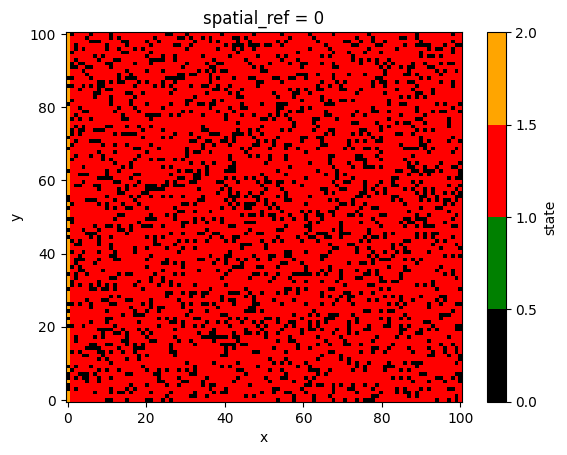

In [2]:
model.plot_state()

[2024-03-09 21:05:47][main           ] | Setting up Forest...
[2024-03-09 21:05:47][nature         ] | Initializing a new Model Layer...
[2024-03-09 21:05:47][nature         ] | Using rioxarray version: 0.13.4
[2024-03-09 21:05:47][main           ] | Ending Forest


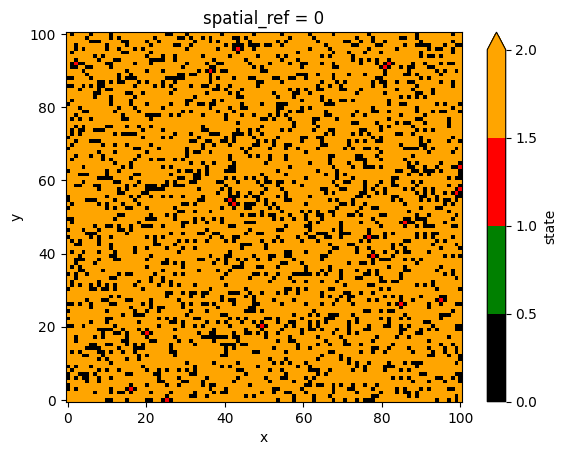

In [3]:
model.run_model()
model.plot_state()

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from abses import MainModel, Actor
from abses.datacollection import DataCollector

# Initialize random number generator
rng = np.random.default_rng(42)

The model needs a grid of cells and trees that will be set on that space. Those are the two basic elements to this model. Tree will inherit from the Actor class and Forest will inherit from the MainModel class. The scaffold of the model would look as follows: 

```python
class Tree(Actor):
    (...)

class Forest(MainModel):
    (...)
```

## The `Tree` Actor Class
At each step, a tree will spread the fire if it has been set on fire. It won't move nor will its behavior deviate from the simple heuristic we will define. 

A tree can only take either of three states. It can be yet untouched and healthy from the fire, it can be on fire or it can be scorched. If the tree is on fire it will spread the fire to its immediate neighbors. Its neighborhood is comprised of the 4 cells that are adjacent to it.

The implementation requires from us a step method that follows our simple heuristic.

Please, note that ABSESpy includes a `PatchCell` object that represents the cells in the grid. It may contain more than one agent or tree. We must impose that it only contains a single tree for the purpose of this model. A `PatchCell` offers the possibility to access an `ActorsList` object, listing all agents at that particular cell, that provides a way to trigger functionality at the tree level.


In [34]:
class Tree(Actor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.state = "INTACT"

    @property
    def is_intact(self):
        return self.state == "INTACT"

    @property
    def is_burning(self):
        return self.state == "BURNING"

    @property
    def is_scorched(self):
        return self.state == "SCORCHED"

    def step(self):
        if self.state == "BURNING":
            for neighbor in self.model.nature.major_layer.iter_neighbors(
                self.pos, moore=False
            ):
                if neighbor.has_agent():
                    neighbor.agents.trigger("ignite")

            self.state = "SCORCHED"

    def ignite(self):
        if self.state == "INTACT":
            self.state = "BURNING"

## The `Forest` MainModel Class
At the model level, we want to instantiate the grid where the trees will live; we want to place the trees randomly on the grid but never two trees on a same patch; we want to set a number of trees on fire to start off the model; we want to have a way to represent the general state of the model. Given those requierements, we can write the Forest class that will inherit from the MainModel class.

We initialize this class by passing some custom parameters and other default parameters. As custom parameters, we want to be able to change the size of the grid and the tree population density. At initialization, we want these things to happen:
1. Add a layer
2. Add agents of the class `Tree`
3. Place them on the grid. No two trees on the same cell.
4. Instantiate a DataCollector object and pass a method to collect revelant data.

Given the simplicity of the interactions between trees, we only need to trigger each tree to spread the fire on each step, if the tree is currently on fire. This implies a simple `step` method that does precisely that. 

A bit more involved, we need a method to extract data that will allow us to peek into the model's evolution. To remain faithful to the original implementation, we want to visualize the whole grid with each cell colored according to the state of the tree that lives on it. A first step to achieve that consist of generating a list of lists (a 2d numpy array in this case) that will mirror the grid. We will then assign numerical values to each of the three possible states of a tree. Finally, we will write those values to the array, thus, creating a representation of the space we can visualize.

In [35]:
class Forest(MainModel):
    def __init__(self, shape, density, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.shape = shape
        self.density = density
        self.num_trees = self.calc_num_trees()

        # Initialize a grid
        self.nature.create_module(how="from_resolution", shape=self.shape)

        # Create initial agents
        self.agents.create(Tree, self.num_trees)

        # Position the agents across the grid and \
        # set initial state 'burning' for leftmost trees
        positions = self.get_trees_pos()

        for i, tree in enumerate(self.actors):
            tree.put_on_layer(layer=self.nature.major_layer, pos=positions[i])

            if positions[i][1] == 0:
                tree.state = "BURNING"

        self.datacollector = DataCollector(
            self, model_reporters={"state": lambda m: m.get_state()}
        )

    def step(self):
        self.actors.trigger("step")
        self.datacollector.collect()

    def calc_num_trees(self):
        return int(self.shape[0] * self.shape[1] * self.density)

    def get_trees_pos(self):
        all_pos_ = [
            c.pos for row in self.nature.major_layer.cells for c in row
        ]
        return rng.choice(all_pos_, size=self.num_trees, replace=False)

    def get_state(self):
        state_ = np.zeros(self.shape)
        for tree in self.actors:
            if tree.is_burning:
                state_[tree.pos] = 0.5
            if tree.is_scorched:
                state_[tree.pos] = 1
            if tree.is_intact:
                state_[tree.pos] = 1.5

        return state_

## Running Simulations
We want to run the model altering just one parameter and comparing models outputs. Holding the `shape` parameter constant, we can evaluate the effect of changes in the tree population density. That is, the number of trees in the grid.

We need a method to visualize the data we collect. We will use matplotlib to plot the model state.

In [57]:
def plot_state(state: np.ndarray, ax=None):
    """Get static grid image"""
    cmap = plt.cm.colors.ListedColormap(["black", "red", "orange", "green"])
    norm = plt.cm.colors.BoundaryNorm([0, 0.5, 1, 1.5, 2], cmap.N)

    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(state, cmap=cmap, norm=norm, interpolation="nearest")
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove spines
    for side in "top,right,bottom,left".split(","):
        ax.spines[side].set_visible(False)

In [37]:
SHAPE = (100, 100)

parameters = {"seed": 42, "time": {"end": 50}}

# Create a battery of models
model35 = Forest(shape=SHAPE, density=0.35, parameters=parameters)
model50 = Forest(shape=SHAPE, density=0.50, parameters=parameters)
model65 = Forest(shape=SHAPE, density=0.65, parameters=parameters)

# Run the simulations
for model in [model35, model50, model65]:
    model.run_model()

[2024-02-04 12:34:15][human          ] | Initializing a new Human Module...
[2024-02-04 12:34:15][nature         ] | Initializing a new Base Nature module...
[2024-02-04 12:34:15][nature         ] | Initializing a new Model Layer...
[2024-02-04 12:34:15][nature         ] | Using rioxarray version: 0.13.4
[2024-02-04 12:34:15][container      ] | Created 3500 actors of breed Tree
[2024-02-04 12:34:15][datacollection ] | DataCollector component initialized.
[2024-02-04 12:34:15][human          ] | Initializing a new Human Module...
[2024-02-04 12:34:15][nature         ] | Initializing a new Base Nature module...
[2024-02-04 12:34:15][nature         ] | Initializing a new Model Layer...
[2024-02-04 12:34:15][nature         ] | Using rioxarray version: 0.13.4
[2024-02-04 12:34:16][container      ] | Created 5000 actors of breed Tree
[2024-02-04 12:34:16][datacollection ] | DataCollector component initialized.
[2024-02-04 12:34:16][human          ] | Initializing a new Human Module...
[2024-

We want to visually inspect the model at different stages. We will pick a step close to the beginning of the simulation, another towards the middle and another towards the end. We will plot the grid at each of those steps for all three models.

After a quick visual inspection we are able to draw some conclusions about the emergent patterns in our model. There appears to be a threshold somewhere around 0.6 where the fire spreads to the whole grid. It would be interesting to explore the overall coverage of the fire for more values of the tree population density. This is left as an exercise for the reader.

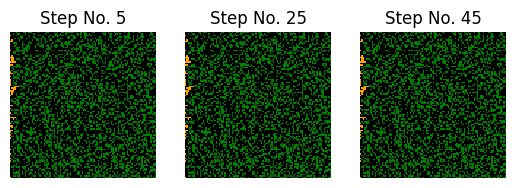

In [63]:
fig, axes = plt.subplots(1, 3)

# Plot the states for a Forest model with 35% tree density
titles = ["Step No. 5", "Step No. 25", "Step No. 45"]

for i, (idx, data) in enumerate(
    model35.datacollector.get_model_vars_dataframe()
    .iloc[[5, 25, -5]]
    .iterrows()
):
    plot_state(data["state"], ax=axes[i])
    axes[i].set_title(titles[i])

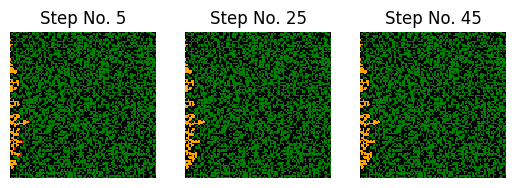

In [65]:
fig, axes = plt.subplots(1, 3)

# Plot the states for a Forest model with 50% tree density
for i, (idx, data) in enumerate(
    model50.datacollector.get_model_vars_dataframe()
    .iloc[[5, 25, -5]]
    .iterrows()
):
    plot_state(data["state"], ax=axes[i])
    axes[i].set_title(titles[i])

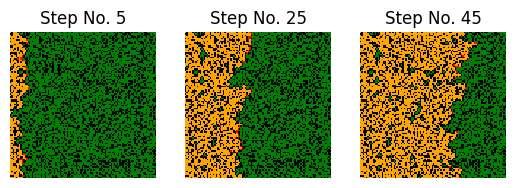

In [64]:
fig, axes = plt.subplots(1, 3)

# Plot the states for a Forest model with 65% tree density
for i, (idx, data) in enumerate(
    model65.datacollector.get_model_vars_dataframe()
    .iloc[[5, 25, -5]]
    .iterrows()
):
    plot_state(data["state"], ax=axes[i])
    axes[i].set_title(titles[i])